## Self-Organizing maps for Anomaly/Fraud Detection



In [1]:
import numpy as np
from numpy.ma.core import ceil
from scipy.spatial import distance #distance calculation
from sklearn.preprocessing import MinMaxScaler #normalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #scoring
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import animation, colors
import pandas as pd

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Helper Functions

In [2]:
# Euclidean distance - used to check for higher dimensional similarity
def e_distance(x,y):
  return distance.euclidean(x,y)

# Manhattan distance - used to check for adjacency in 2d neuron grid
def m_distance(x,y):
  return distance.cityblock(x,y)

# Best Matching Unit search
def winning_neuron(data, t, som, num_rows, num_cols):
  winner = [0,0]
  shortest_distance = np.sqrt(data.shape[1]) # initialise with max distance
  input_data_instance = data[t]
  for row in range(num_rows):
    for col in range(num_cols):
      distance = e_distance(som[row][col], input_data_instance) # som - 2d lattice of neurons
      if distance < shortest_distance: 
        shortest_distance = distance
        winner = [row,col] # coordinates of winner neuron in som
  return winner

# Learning rate and neighbourhood range calculation for a given step
def decay(step, max_steps,max_learning_rate,max_m_distance):
  coefficient = 1.0 - (np.float64(step)/max_steps)
  learning_rate = coefficient*max_learning_rate # as num_steps for an iteration increases, learning rate decreases
  neighbourhood_range = ceil(coefficient * max_m_distance) # similarly, neighbourhood range also decreases
  return learning_rate, neighbourhood_range

# Data Preprocessing

In [3]:
df = pd.read_csv('/kaggle/input/fraud-detection-competition/train_transaction.csv')
df.isnull().sum() 

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
                   ...  
V335              351771
V336              351771
V337              351771
V338              351771
V339              351771
Length: 394, dtype: int64

In [4]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df = df.fillna(df.mean())

df = df.drop(['R_emaildomain'], axis=1) # RAM Constraint
df = df.drop(df[~ (df['card4'] == 'visa') & ~ (df['card4'] == 'mastercard')].index)
df = df.drop(df[~ (df['P_emaildomain'] == 'gmail.com') & ~ (df['P_emaildomain'] == 'yahoo.com')].index)

data_x = df.drop(['isFraud'], axis =1)
data_y = df.loc[:,'isFraud']

/tmp/ipykernel_20/3024276667.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df.fillna(df.mean())


<AxesSubplot: >

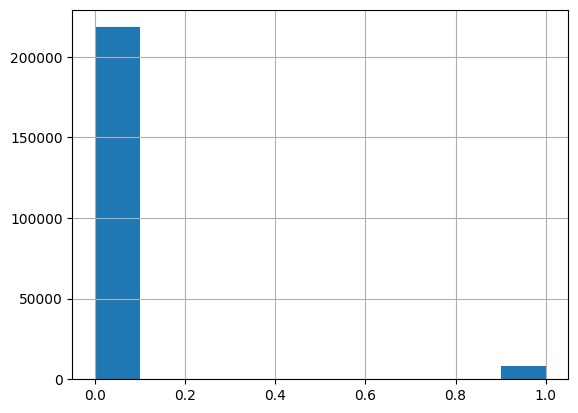

In [6]:
data_y.hist()

### Label Encoding

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(["T","F",'n'])

for i,k in enumerate(['M1','M2','M3','M5','M6','M7','M8','M9']):
  data_x[k] = le.transform(data_x[k])

### One Hot Encoding

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# queriedColumns = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M4'] # RAM Constraint
queriedColumns = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M4'] # RAM Constraint

indexes = []
for i, k in enumerate(queriedColumns): 
  indexes.append(data_x.columns.get_loc(k))

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse_output=False) , indexes)], remainder = 'passthrough')
data_x = np.array(ct.fit_transform(data_x)).astype('float32')

#### Note: train_y (labels) is used only for label collection in Approach 1: Correct labels assigned to clusters. It is ignored in Approach 2: Unsupervised Clustering.

In [9]:
train_x, val_x, train_y, val_y = train_test_split(data_x, data_y, test_size=0.5, random_state=42)
print(f'Shapes: {train_x.shape} | {train_y.shape} | {val_x.shape} | {val_y.shape}') # check the shap

sc = MinMaxScaler(feature_range=(0,1))
train_x_scaled = sc.fit_transform(train_x) # normalization
val_x_scaled = sc.transform(val_x)

Shapes: (113388, 403) | (113388,) | (113388, 403) | (113388,)


# Training

### Hyperparameters

In [10]:
num_rows = 25 # ~ sqrt(sqrt(train_x.shape[0]))
num_cols = 25 # ~ sqrt(sqrt(train_x.shape[0]))
max_m_distance = 15
max_learning_rate = 0.5
max_steps = int(300000) #  ~ 500 * num_rows * num_cols

### Additional Helper Function:

#### Adjusting Neighbours' Weights


$ W(t + 1) = W(t) + \Theta(t) * \lambda(t) * (V(t) - W(t)) $


$ \Theta = exp(-\frac{dist^{2}}{2 r^{2} (t)}) $  
$ \Theta $ depends on the time and the distance of the neuron to the BMU &arr; Ensures that the weights are adjusted particularly strongly for neurons close to the BMU

##### r = neighbourhood range / radius
##### t = time / steps 
##### dist = distance of given neighbour neuron from BMU 

$ \lambda $ is the learning rate and can be freely chosen

In [11]:
import math

def neighbourFunction(dist, r, t):
  funcOutput = math.exp(0-(dist*dist)/(2*r*r*t))
  return funcOutput 

In [12]:
num_dims = train_x_scaled.shape[1] # numnber of dimensions in the input data

np.random.seed(2)

som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # neuron 2d lattice - map construction

for step in range(max_steps):
  if (step+1) % 10000 == 0:
      print("Iteration: ", step+1) # print out the current iteration for every 10k

  learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_m_distance)

  t = np.random.randint(0,high=train_x_scaled.shape[0]) # random index of training data
  winner = winning_neuron(train_x_scaled, t, som, num_rows, num_cols)

  for row in range(num_rows):
    for col in range(num_cols):
      if m_distance([row,col],winner) <= neighbourhood_range:
        if(row==winner[0] and col == winner[1]):
          som[row][col] += learning_rate*(train_x_scaled[t]-som[row][col]) # update BMU's weights
        else:
          neighbourFunc = neighbourFunction(m_distance([row,col],winner), neighbourhood_range, (step+1))
          som[row][col] +=  neighbourFunc * learning_rate*(train_x_scaled[t]-som[row][col]) # update neighbours' weights

Iteration:  10000
Iteration:  20000
Iteration:  30000
Iteration:  40000
Iteration:  50000
Iteration:  60000
Iteration:  70000
Iteration:  80000
Iteration:  90000
Iteration:  100000
Iteration:  110000
Iteration:  120000
Iteration:  130000
Iteration:  140000
Iteration:  150000
Iteration:  160000
Iteration:  170000
Iteration:  180000
Iteration:  190000
Iteration:  200000
Iteration:  210000
Iteration:  220000
Iteration:  230000
Iteration:  240000
Iteration:  250000
Iteration:  260000
Iteration:  270000
Iteration:  280000
Iteration:  290000
Iteration:  300000


# Approach 1: Correct Labels Assigned to Clusters. 

#### Clusters are already formed in the self organizing map. Labels can be assigned to each neuron in the map, and inputs can be assigned to each neuron to determine their class (Fraud/Not Fraud)

> ## Collecting Labels

In [13]:
label_data = train_y.values
map = np.empty(shape=(num_rows, num_cols), dtype=object)

for row in range(num_rows):
  for col in range(num_cols):
    map[row][col] = [] # em

In [14]:
for t in range(train_x_scaled.shape[0]):
  if (t+1) % 10000 == 0:
    print("sample data: ", t+1)
  winner = winning_neuron(train_x_scaled, t, som, num_rows, num_cols)
  map[winner[0]][winner[1]].append(label_data[t])

sample data:  10000
sample data:  20000
sample data:  30000
sample data:  40000
sample data:  50000
sample data:  60000
sample data:  70000
sample data:  80000
sample data:  90000
sample data:  100000
sample data:  110000


In [15]:
import statistics
import matplotlib.colors as mcolors
import matplotlib.cm as cm

label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.float32)

for row in range(num_rows):
  for col in range(num_cols):
    label_list = map[row][col]
    if len(label_list)==0:
      label = 0 # Identified Classes Included
    else:
      label = label_list.count(1)/len(label_list)
    label_map[row][col] = label

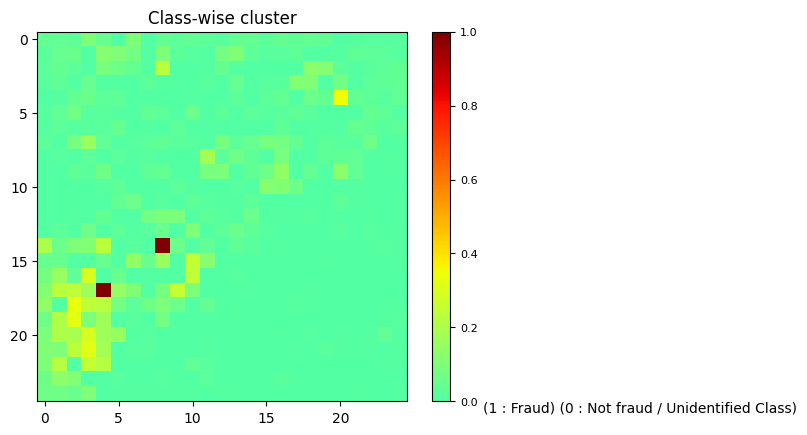

In [16]:
title = ('Class-wise cluster' )

from PIL import Image
import requests
from io import BytesIO

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = truncate_colormap(plt.get_cmap('jet'), 0.45, 1.0)

plt.title(title)

plt.imshow(label_map, cmap=cmap)

clb=plt.colorbar()
clb.ax.tick_params(labelsize=8) 
clb.set_label('(1 : Fraud) (0 : Not fraud / Unidentified Class)',loc='bottom', rotation=0)

plt.show()

# Approach 2: Unsupervised Clustering. 

 Clusters are already formed in the self organizing map. However, we can ignore train_y, and consider the scenario where we don't have access to data labels (no information of whether a given transaction is fraud/not-fraud).

 The Self Organizing Map is an unsupervised clustering technique. Interneuron distance of every neuron to neighbouring neurons may be computed to search for members of a cluster that show the most abnormal behavior / difference in weights. Any data instance (transaction) assigned to a neuron/BMU with the highest interneuron distance may be considered to be fraudulent.

In [17]:
def fast_norm(x):
    """Returns norm-2 of a 1-D numpy array.
    """
    return math.sqrt(np.dot(x, x.T))

def distance_map(map):
        """Returns the distance map of the weights.
        Each cell is the normalised sum of
        the distances between a neuron and its neighbours. Note that this
        method uses the euclidean distance. *Partly copied from JustGlowing/Minisom Github project* """
        
        ii = [[0, -1, -1, -1, 0, 1, 1, 1]]*2
        jj = [[-1, -1, 0, 1, 1, 1, 0, -1]]*2
        
        um = np.nan * np.zeros((som.shape[0],
                          som.shape[1],
                          8)) 
        
        for x in range(som.shape[0]):
            for y in range(som.shape[1]):
                neuron2 = som[x, y]
                e = y % 2 == 0   # only used on hexagonal topology
                for k, (i, j) in enumerate(zip(ii[e], jj[e])):
                    if (x+i >= 0 and x+i < som.shape[0] and
                            y+j >= 0 and y+j < som.shape[1]):
                        neuron1 = som[x+i, y+j]
                        um[x, y, k] = fast_norm(neuron2-neuron1)
                        
        um = np.nansum(um, axis=2)
        
        return um/um.max()

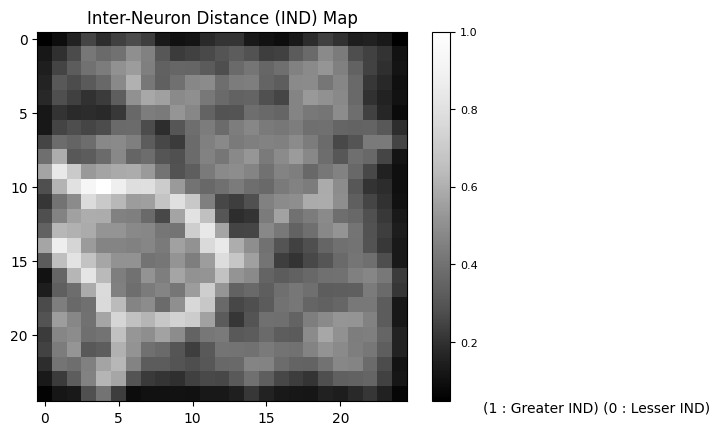

In [18]:
title = ('Inter-Neuron Distance (IND) Map' )

dist_map = distance_map(som)
plt.title(title)

cmap = cm.get_cmap('Greys_r')

plt.imshow(dist_map, cmap=cmap)

clb=plt.colorbar()
clb.ax.tick_params(labelsize=8) 
clb.set_label('(1 : Greater IND) (0 : Lesser IND)', rotation=0, loc = 'bottom')

plt.show()

## Testing both approaches

### Approach 1:

#### Every neuron has been assigned mean class value of range 0-1. Threshold for fraudulent will be considered > 0.75

In [19]:
true_labels = val_y
predicted_labels = []

for i, k in enumerate(val_x_scaled):
    winner = winning_neuron(val_x_scaled, i, som, 16, 16)
    winner_class = label_map[winner[0]][winner[1]]
    predicted_labels.append(1 if winner_class > 0.5 else 0)

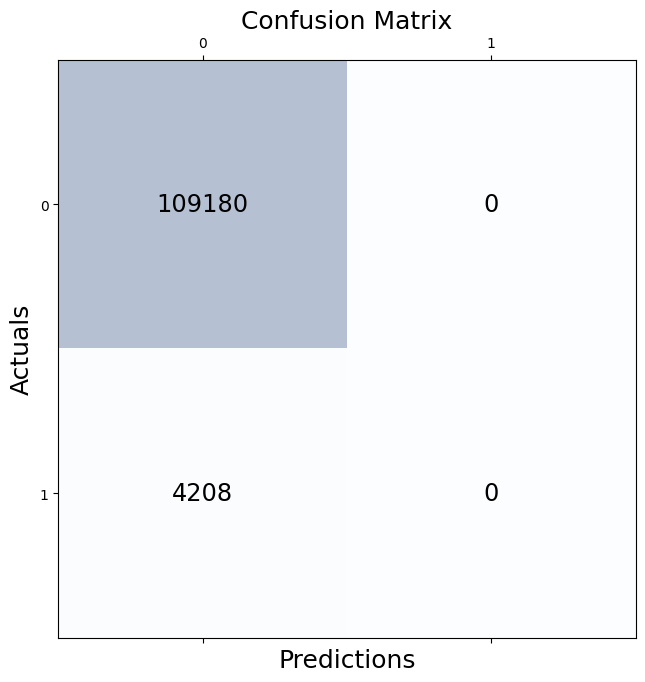

In [20]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true=true_labels, y_pred=predicted_labels)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=cm.Blues, alpha=0.3)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)

plt.show()

In [21]:
from sklearn.metrics import accuracy_score

print(f'Accuracy Score: {round(accuracy_score(y_true=true_labels, y_pred=predicted_labels),2)*100}%')

Accuracy Score: 96.0%


### Approach 2:

#### Every unit has been assigned normalized IND of range 0-1. Threshold for fraudulent will be considered > 0.75

In [22]:
true_labels = val_y
predicted_labels = []

for i, k in enumerate(val_x_scaled):
    winner = winning_neuron(val_x_scaled, i, som, 16, 16)
    winner_class = dist_map[winner[0]][winner[1]]
    predicted_labels.append(1 if winner_class > 0.65 else 0)

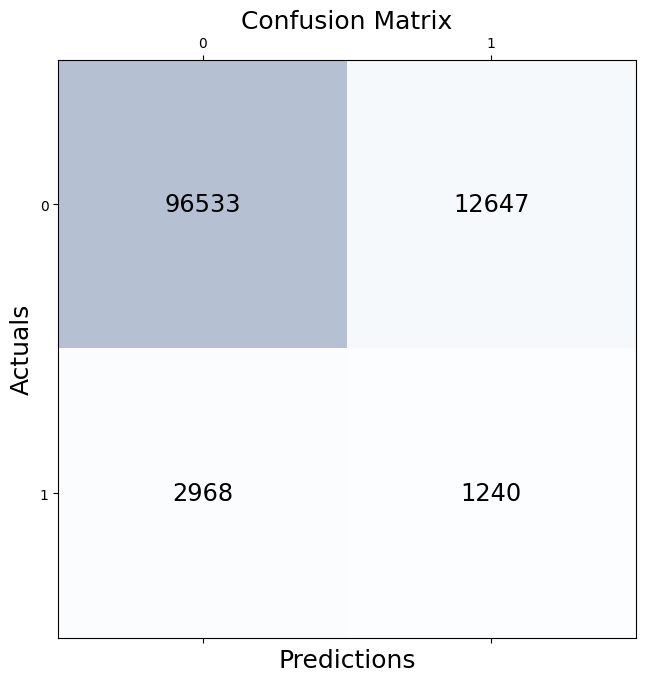

In [23]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true=true_labels, y_pred=predicted_labels)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=cm.Blues, alpha=0.3)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)

plt.show()

In [24]:
from sklearn.metrics import accuracy_score

print(f'Accuracy Score: {round(accuracy_score(y_true=true_labels, y_pred=predicted_labels),2)*100}%')

Accuracy Score: 86.0%
